In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ito_shibata import shibata_act
from experiments.ito_firek import firek_inact
from experiments.ito_nygren import nygren_inact_kin, nygren_rec
from experiments.ito_wang import wang_act, wang_inact
from experiments.ito_courtemanche import (courtemanche_act_kin,
                                          courtemanche_inact_kin,
                                          courtemanche_rec,
                                          courtemanche_deact)

In [5]:
modelfile = 'models/courtemanche_ito.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

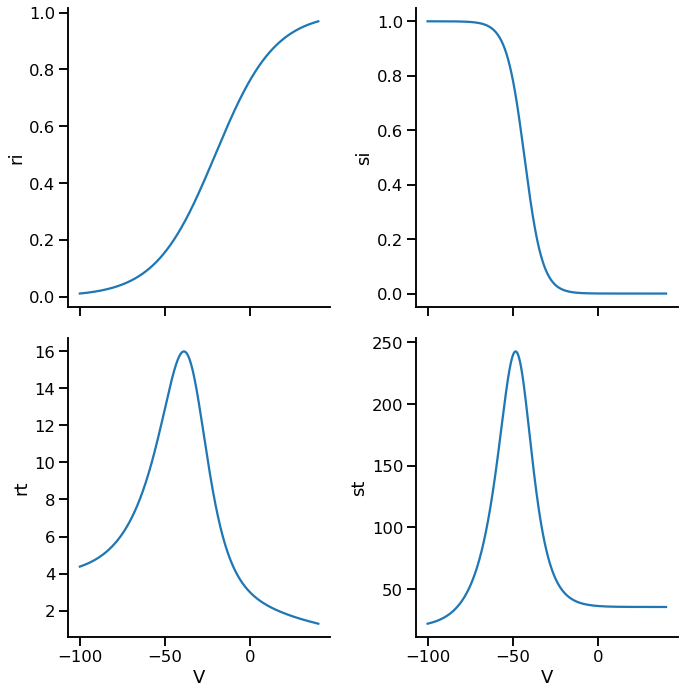

In [7]:
sns.set_context('talk')

V = np.arange(-100, 40, 0.01)

cou_vars = {'ri': 'ito.a_inf',
            'si': 'ito.i_inf',
            'rt': 'ito.tau_a',
            'st': 'ito.tau_i'}

f, ax = plot_variables(V, cou_vars, modelfile, figshape=(2,2))

## a gate -> Activation data only

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act,
                                                courtemanche_act_kin,
                                                courtemanche_deact)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

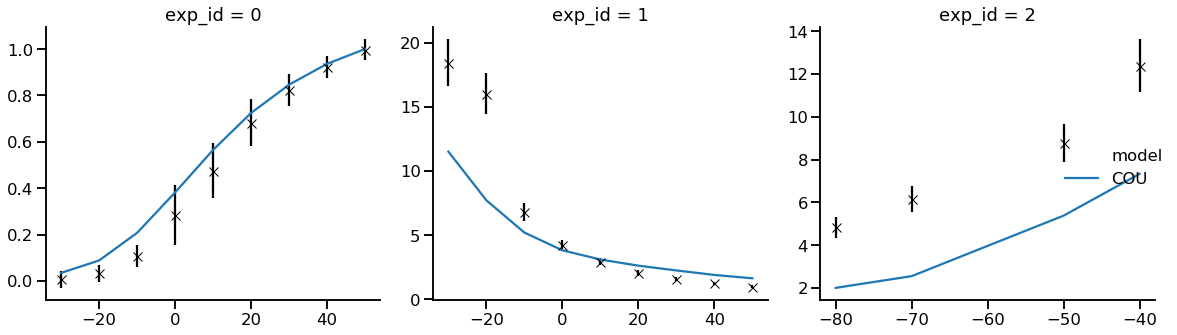

In [10]:
g = plot_sim_results(modelfile,
                     wang_act,
                    courtemanche_act_kin,
                    courtemanche_deact)

In [11]:
limits = {'ito.p1': (-100, 100),
          'ito.p2': (1e-7, 50),
          'log_ito.p3': (-3, 2),
          'ito.p4': (-100, 100),
          'ito.p5': (1e-7, 50),
          'ito.p6': (-100, 100),
          'ito.p7': (1e-7, 50),
          'log_ito.p8': (-3, 2),
          'ito.p9': (-100, 100),
          'ito.p10': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ito_agate_reported.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9863674644064488, '1': 0.9863674644064488, '2': 0.9863674644064488, '3': 0.38080068442521287, '4': 0.41009304476561353, '5': 0.48465541654118166, '6': 0.7108279442603979, '7': 0.9863674644064488, '8': 0.9863674644064488, '9': 0.4931837322032244, '10': 0.5675655409945304, '11': 0.9863674644064488, '12': 0.9863674644064488, '13': 0.9863674644064488, '14': 0.9863674644064488, '15': 0.9863674644064488, '16': 0.9863674644064488, '17': 0.9863674644064488, '18': 2.21932679491451, '19': 2.21932679491451, '20': 1.5681470766461805, '21': 1.109663397457255}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-23 21:42:28.102724, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [19]:
history = History(db_path)

In [20]:
df, w = history.get_distribution()

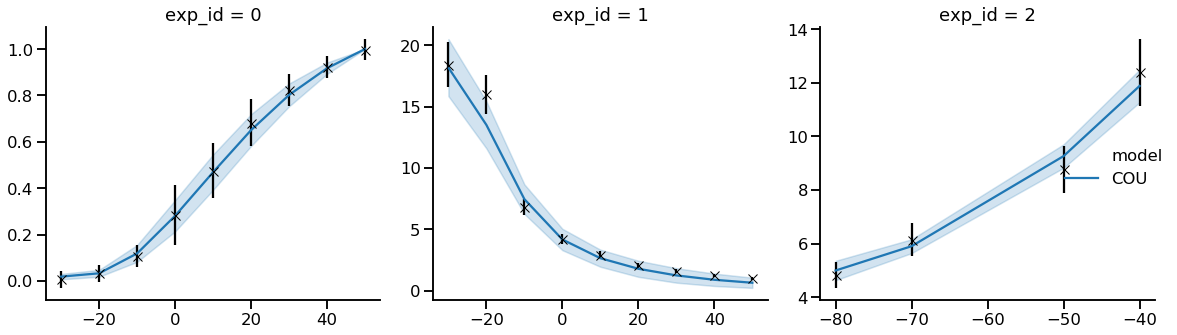

In [21]:
g = plot_sim_results(modelfile,
                     wang_act,
                    courtemanche_act_kin,
                    courtemanche_deact,
                     df=df, w=w)

In [22]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

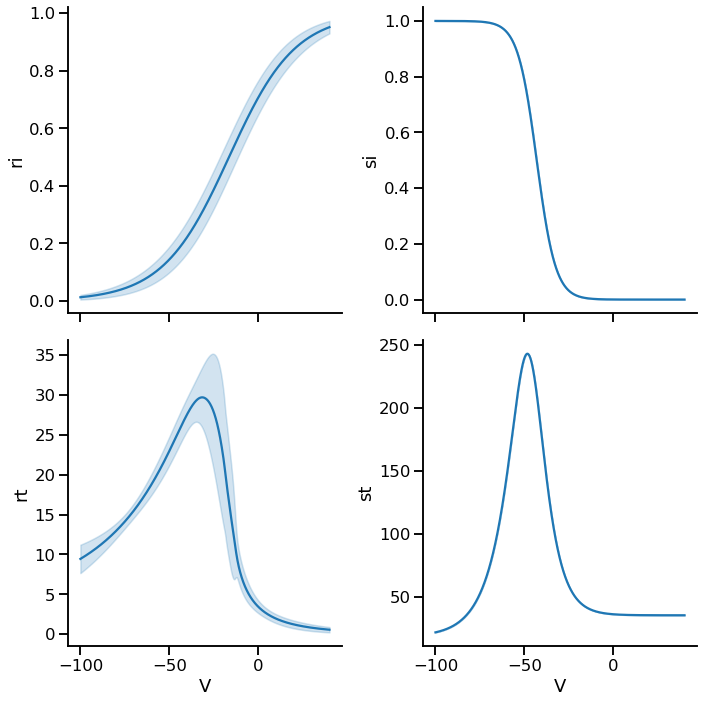

In [23]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ito.mmt', 
                       [cou_pars],
                       figshape=(2,2))

In [24]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [25]:
m,_,_ = myokit.load(modelfile)

In [26]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

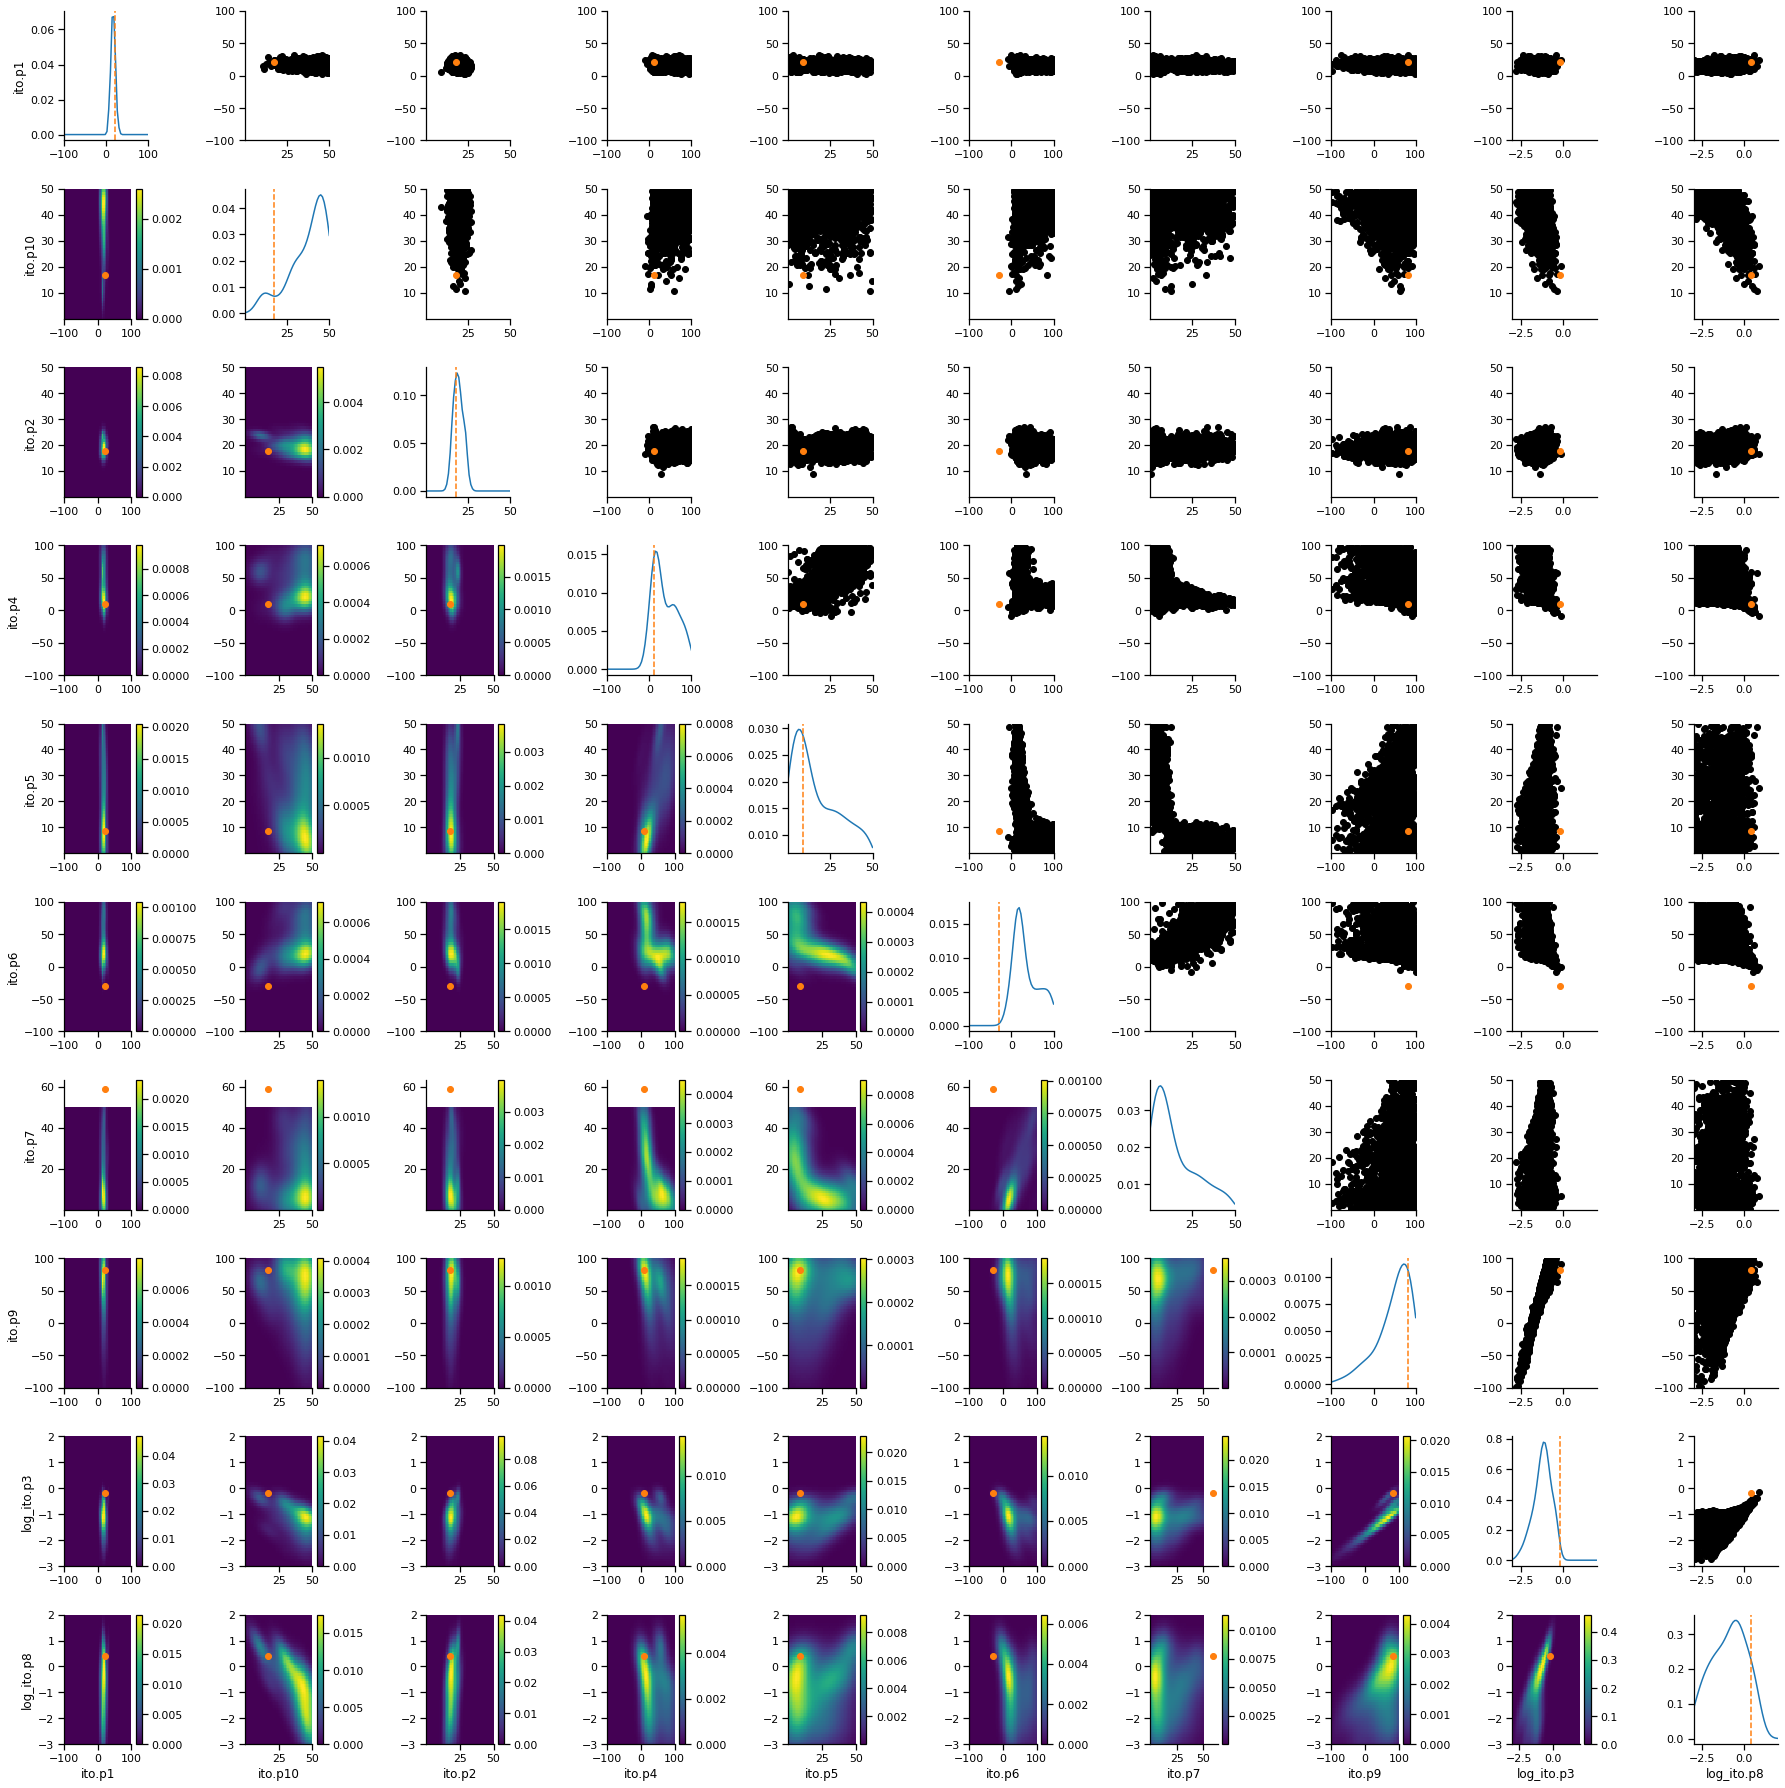

In [27]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

## i gate -> Inactivation data only

In [40]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_inact,
                                                courtemanche_inact_kin,
                                                courtemanche_rec)

In [41]:
assert len(observations)==len(summary_statistics(model({})))

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


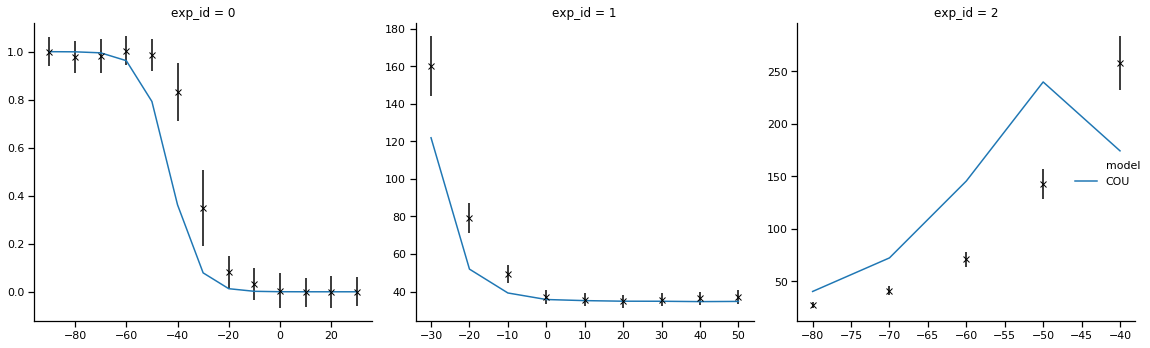

In [42]:
g = plot_sim_results(modelfile,
                     wang_inact,
                    courtemanche_inact_kin,
                    courtemanche_rec)

In [43]:
limits = {'ito.q1': (-100, 100),
          'ito.q2': (1e-7, 50),
          'log_ito.q3': (-1, 4),
          'ito.q4': (0, 200),
          'ito.q5': (1e-7, 50),
          'log_ito.q6': (-1, 4),
          'ito.q7': (-100, 100),
          'ito.q8': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [44]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ito_igate_reported.db"))

In [45]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 256 particles


In [46]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.6781868948071604, '1': 0.6216713202398976, '2': 0.5738504494522136, '3': 0.6781868948071604, '4': 0.6216713202399009, '5': 0.33909344740358116, '6': 0.25724330492685465, '7': 0.6216713202398976, '8': 0.621671320239904, '9': 0.5738504494522165, '10': 0.6781868948071643, '11': 0.621671320239904, '12': 0.6781868948071643, '13': 0.591589473692273, '14': 1.183178947384546, '15': 1.183178947384546, '16': 1.183178947384546, '17': 1.183178947384546, '18': 1.183178947384546, '19': 1.183178947384546, '20': 1.183178947384546, '21': 1.183178947384546, '22': 2.1297221052921826, '23': 2.1297221052921826, '24': 2.1297221052921826, '25': 1.9238097470457012, '26': 1.0648610526460913}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [47]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [48]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-20 08:23:55.815658, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [50]:
history = History(db_path)

In [51]:
df, w = history.get_distribution()

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


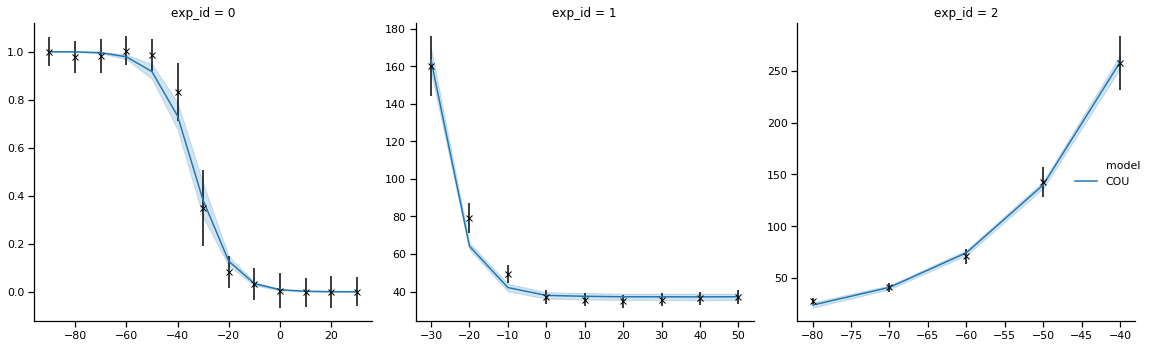

In [52]:
g = plot_sim_results(modelfile,
                     wang_inact,
                    courtemanche_inact_kin,
                    courtemanche_rec,
                     df=df, w=w)

In [53]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

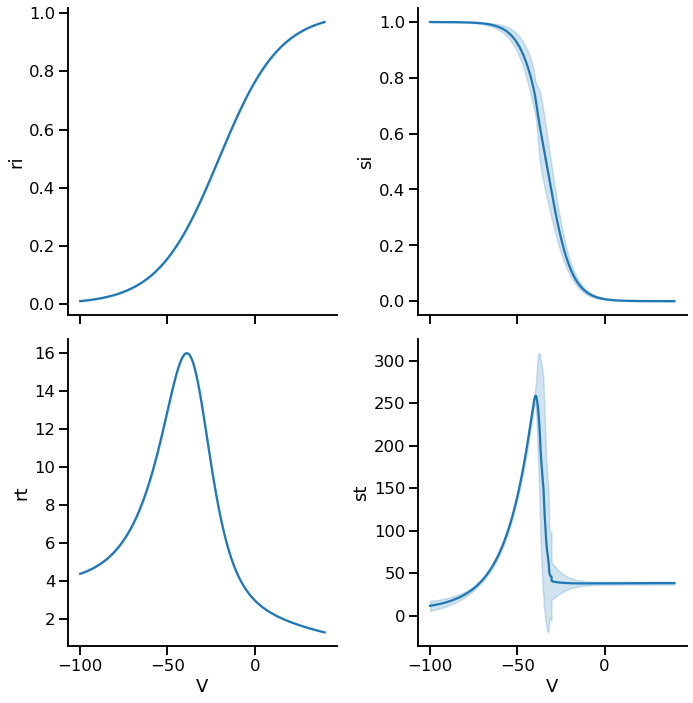

In [54]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ito.mmt', 
                       [cou_pars],
                       figshape=(2,2))

In [55]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [56]:
m,_,_ = myokit.load(modelfile)

In [57]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

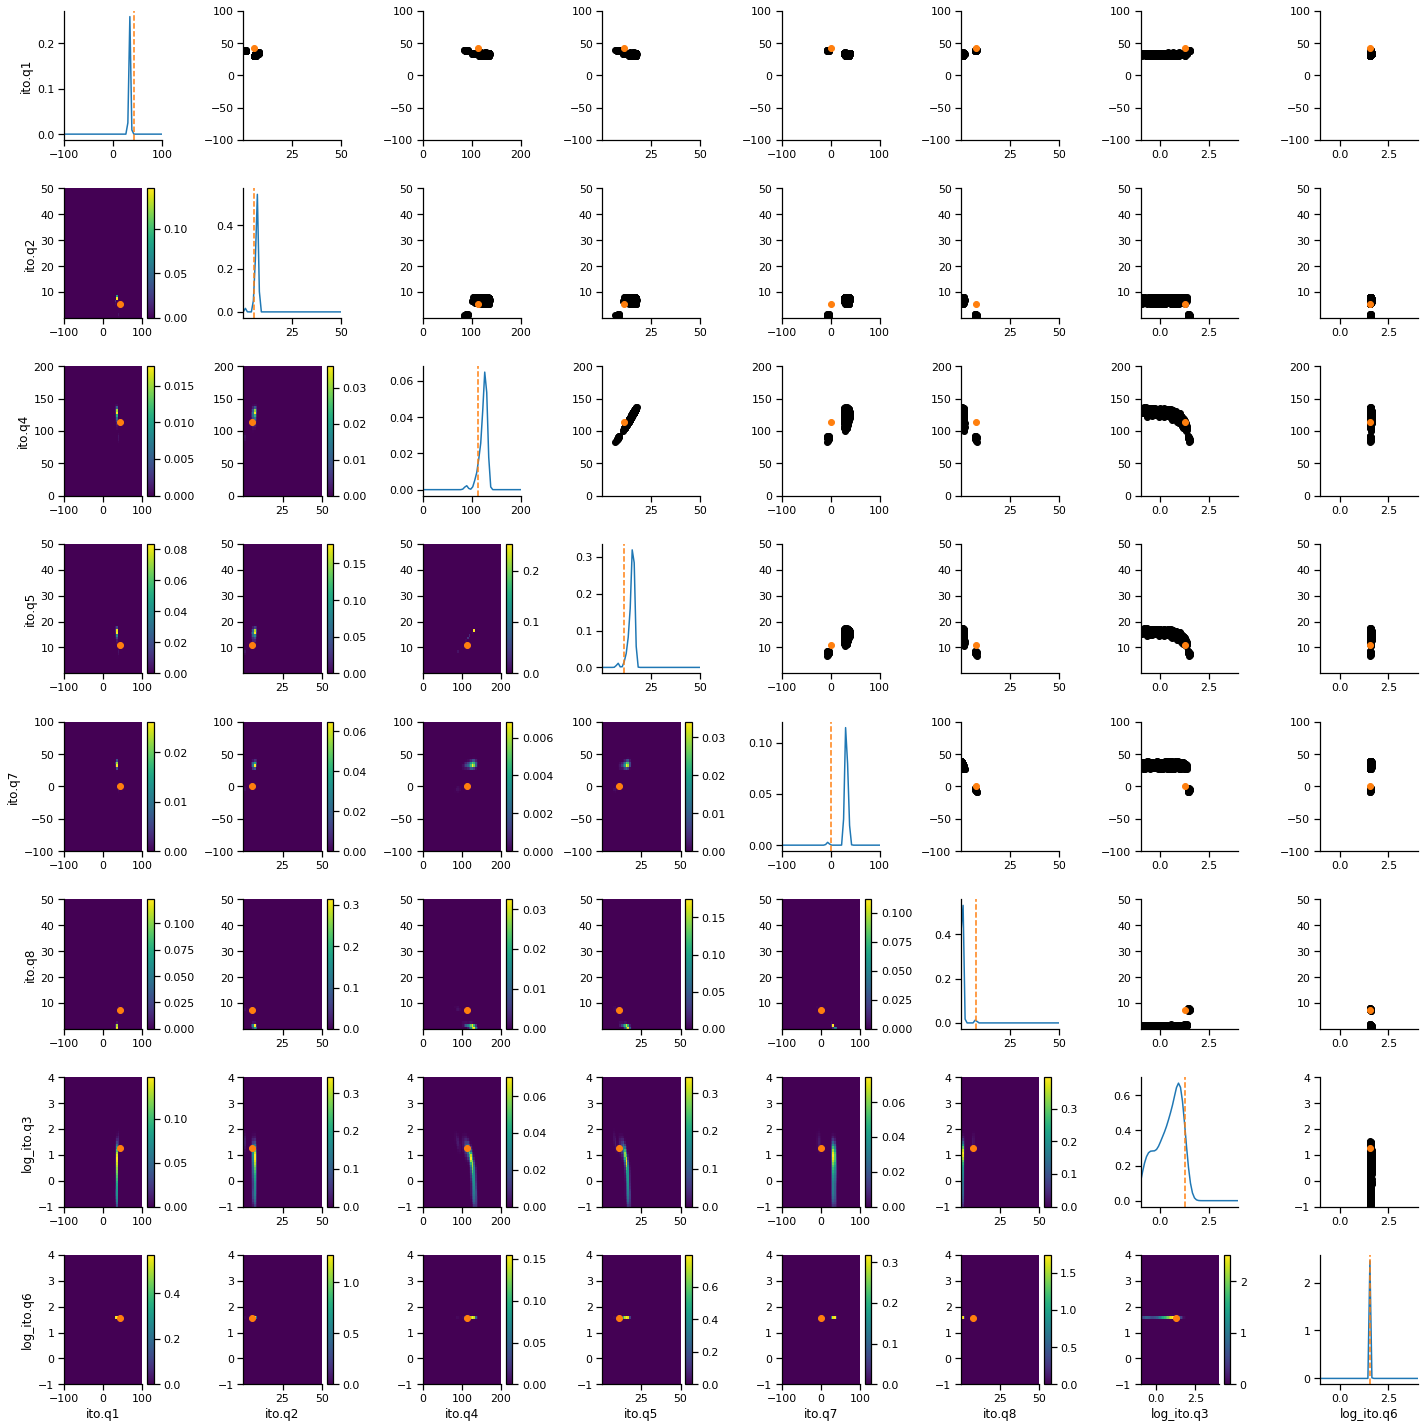

In [58]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)